# シェアバイクの需要予測


## 写経
https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

In [2]:
from datetime import datetime

import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
import matplotlib.pyplot as plt
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
# データの読み込み
dailyData = pd.read_csv('data/train.csv')

## データの統計量

In [4]:
print('shape: ', dailyData.shape)

shape:  (10886, 12)


In [5]:
dailyData.head(2)

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40

In [6]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## 特徴エンジニアリング
- 'datetime'カラムから、'date', 'hour', 'weekDay', 'month'カラムを作成
- 'season', 'holiday', 'workingday', 'weather'をintからcategoryに変換
- 最後に'datetime'カラムを削除

In [7]:
# 新しいカラムの作成
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

# 型変換
categoryVariableList = ['hour', 'weekday', 'month', 'season', 'weather', 'holiday', 'workingday']
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype('category')

# 不要なカラムの削除
dailyData = dailyData.drop(['datetime'], axis=1)

In [8]:
dailyData.head(2)

season holiday workingday  \
0  Spring       0          0   
1  Spring       0          0   

                                             weather  temp   atemp  humidity  \
0   Clear + Few clouds + Partly cloudy + Partly c...  9.84  14.395        81   
1   Clear + Few clouds + Partly cloudy + Partly c...  9.02  13.635        80   

   windspeed  casual  registered  count        date hour   weekday    month  
0        0.0       3          13     16  2011-01-01   00  Saturday  January  
1        0.0       8          32     40  2011-01-01   01  Saturday  January

## 可視化

In [9]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig, ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

TypeError: data type "" not understood

In [13]:
dailyData.dtypes.value_counts()

int64       4
float64     3
category    2
category    1
object      1
category    1
category    1
category    1
category    1
dtype: int64

## 欠損値処理
データに欠損値があるかの確認。missinognoモジュールで手軽に可視化できる。
### 歪度（skewness）

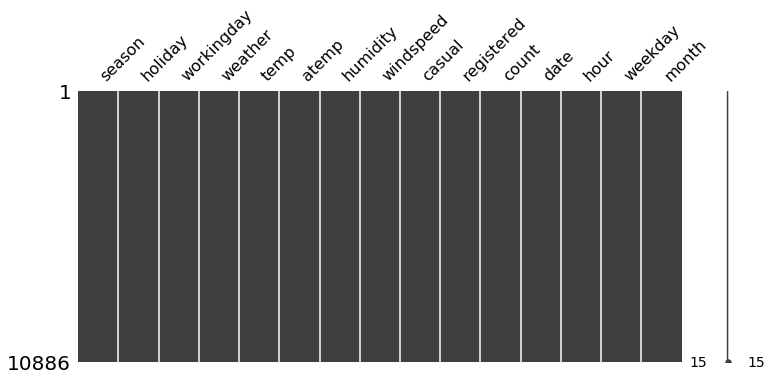

In [14]:
msno.matrix(dailyData, figsize=(12, 5))


## 外れ値
箱ひげ図をプロットする
- 'count' は外れ値を多く含んでおり、右に裾野が長い歪んだ分布になっている
- 季節 'Spring' は比較的レンタル数（count）が少ない
- 時間帯ごとのレンタル数を見ると、7-8, 17-18の値が比較的大きい。多分通勤通学に使用されるため
- 多くの外れ値は平日に発生している

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

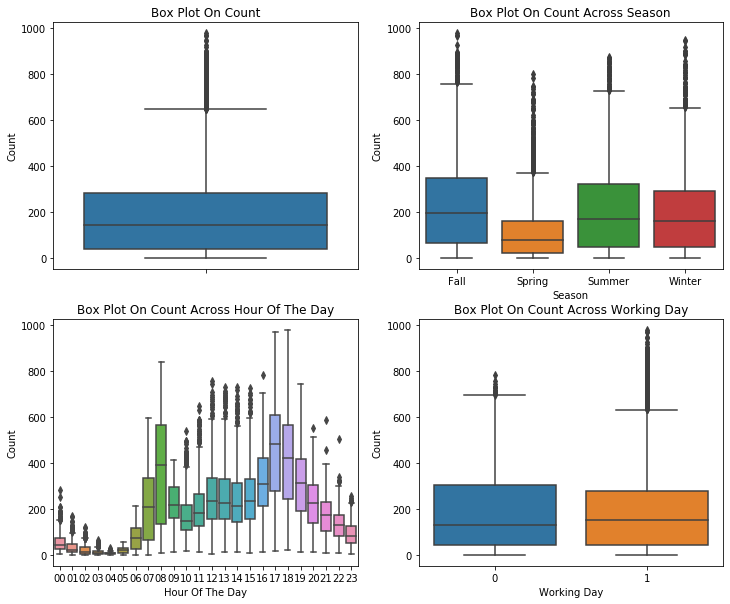

In [17]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

## 外れ値の除去

In [18]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 

print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


## 相関解析
countとの相関を見てみる
- 'temp'と'humidity'はそれぞれ0.39, -0.32の相関係数。しかし'temp'⇔'humidity'は0.091
- 'windspeed'との相関係数は小さく、あまり有用な数値的特徴がないかも
- 'atemp'⇔'temp'の相関係数が高すぎる。多重共線性を引き起こす恐れがあるため、モデル作成時にはどちらかを落とす
- 'Casual'と'Registerd'はleakageなので、モデル作成時には落とす必要がある

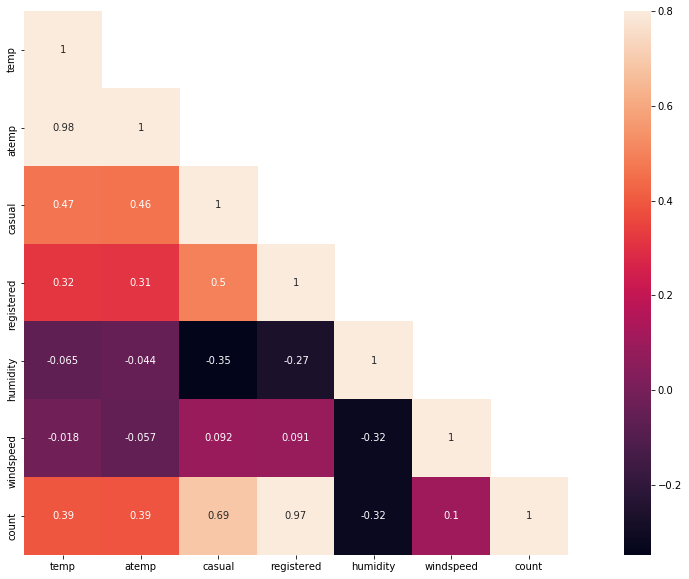

In [19]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

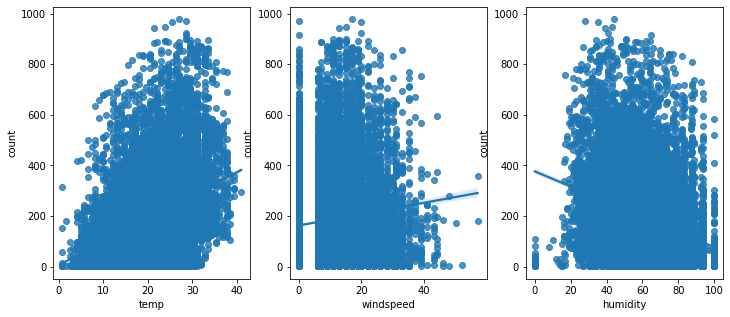

In [20]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=dailyData,ax=ax1)
sn.regplot(x="windspeed", y="count", data=dailyData,ax=ax2)
sn.regplot(x="humidity", y="count", data=dailyData,ax=ax3)

## データの分布の可視化
'count'の分布を見てみる
- 普通にプロット（上段）すると、明らかに正規分布に従っていない。一般的な機械学習手法では正規分布のほうが望ましい
- データを正規分布にするために、対数変換がよく用いられる（下段）
    - 良くなっているように見えるが、まだ正規分布ではない


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229767, 4.562423868087808, 0.958117678090961))

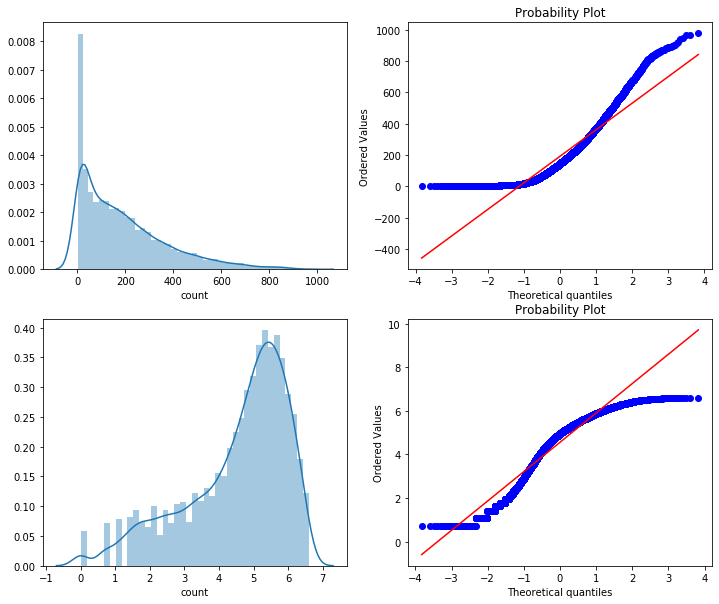

In [21]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["count"],ax=axes[0][0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

## 可視化（Count vs. month, season, hour, weekday, usertype）
- 夏にバイクがよくレンタルされる傾向
- 前で述べたように、平日7-8, 17-18時に通勤通学のため利用する人がおおい
- 土日は10-16時ごろに借りる人が多い
- 平日7-8, 17-18時に借りるのは'registered'のユーザーが多い

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

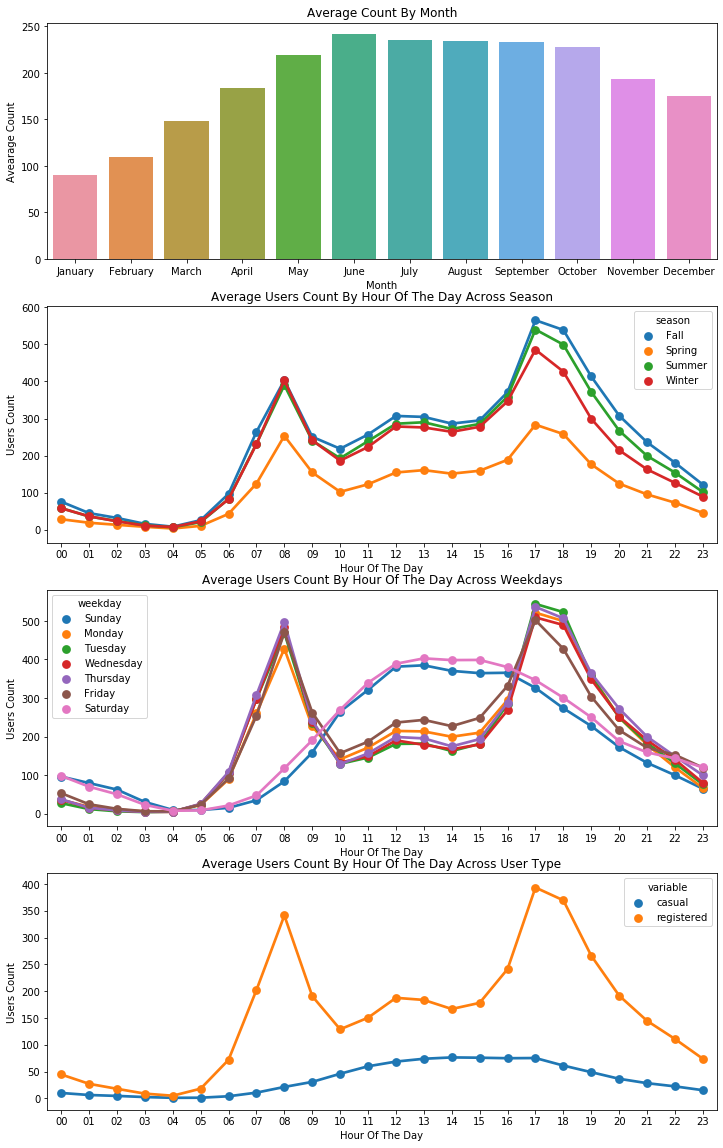

In [22]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

## 特徴設計
- ランダムフォレストを使ってwindspeedの0を推定して埋める

In [32]:
dataTrain = pd.read_csv("./data/train.csv")
dataTest = pd.read_csv("./data/test.csv")

In [33]:
# Test と Trainを結合
data = dataTrain.append(dataTest)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

### 特徴量作成


In [34]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

### Random Forestを使ってwindspeedを推定

In [36]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

### カテゴリカルデータに変換

In [37]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

### 再度TrainとTestに分割

In [39]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]

### 不要な変数を削除
dropFeatures = \['casual',"count","datetime","date","registered"]

In [40]:
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)

### 評価関数(対数平均二乗誤差, RMSLE)

In [41]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

## 線形回帰

In [42]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels)
lModel.fit(X = dataTrain,y = yLabelsLog)

# Make predictions
preds = lModel.predict(X= dataTrain)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Linear Regression:  0.977961232744612


## 正則化モデル（Ridge）

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9779612176690251


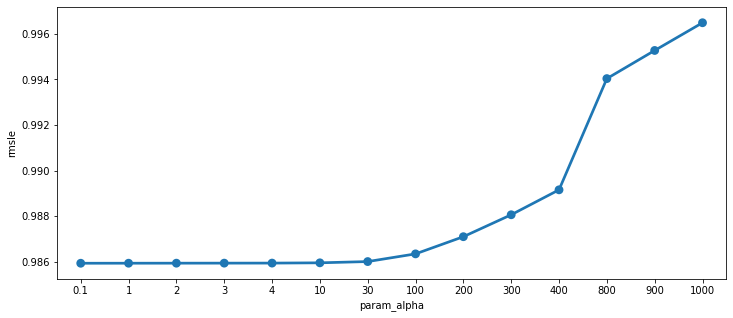

In [52]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit( dataTrain, yLabelsLog )
preds = grid_ridge_m.predict(X= dataTrain)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
# df = pd.DataFrame(grid_ridge_m.grid_scores_)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="param_alpha",y="rmsle",ax=ax)

## 正則化モデル（Lasso）

{'alpha': 0.005, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9780981247956453


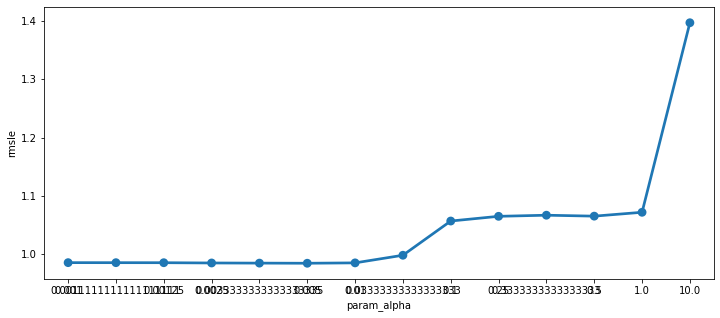

In [53]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit( dataTrain, yLabelsLog )
preds = grid_lasso_m.predict(X= dataTrain)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.cv_results_)
#df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="param_alpha",y="rmsle",ax=ax)

## アンサンブルモデル（Random Forest）

In [54]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest:  0.10300354637297814


## アンサンブルモデル（勾配Boost）

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Gradient Boost:  0.18905137291034896


## 検証
TrainとTest結果の分布を眺める。どちらも同様に見える

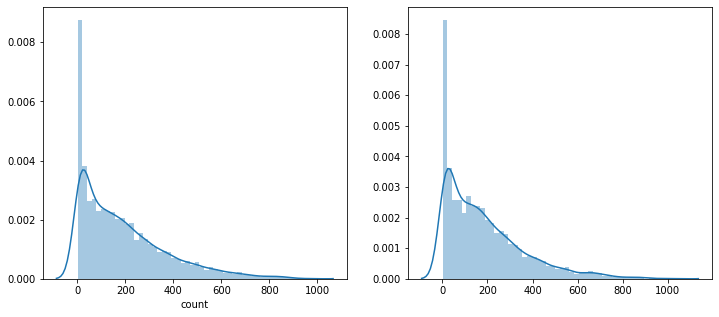

In [57]:
predsTest = gbm.predict(X= dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.distplot(yLabels,ax=ax1,bins=50)
sn.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [59]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_gbm_separate_without_fe.csv', index=False)